In [253]:
import typing as t
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from torch.utils.data import Dataset, DataLoader

In [254]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [255]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [256]:
DATA_DIR = Path("../data/")

CUDA = "cuda"
CPU = "cpu"
DEVICE = CUDA if torch.cuda.is_available() else CPU
print(f"Using {DEVICE.upper()} device")

Using CUDA device


## Предобработка данных и подготовка датасета

In [257]:
def unique_stat(df: pd.DataFrame) -> pd.Series:
    uniq_stat = df.nunique()
    return uniq_stat[(uniq_stat == 1) | (uniq_stat == len(df))]


def na_stat(df: pd.DataFrame) -> pd.Series:
    stat = df.isna().sum()
    return stat[stat > 0]


def duplicates_stat(df: pd.DataFrame) -> pd.Series:
    return df[df.duplicated()].value_counts()


def get_categorical_columns(df: pd.DataFrame) -> pd.Index:
    return df.select_dtypes(object).columns


def get_numerical_columns(df: pd.DataFrame) -> pd.Index:
    return df.select_dtypes(np.number).columns


def count_categories(df: pd.DataFrame) -> pd.Series:
    return df[get_categorical_columns(df)].nunique()

In [258]:
hr_df: pd.DataFrame = pd.read_csv(DATA_DIR / "classification/hr_analytics.csv")
print(hr_df.shape)
hr_df.head()

(4410, 24)


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


In [259]:
uniq_stat = unique_stat(hr_df)
uniq_stat

EmployeeCount       1
EmployeeID       4410
Over18              1
StandardHours       1
dtype: int64

In [260]:
hr_df = hr_df.drop(columns=uniq_stat.index)
unique_stat(hr_df)

Series([], dtype: int64)

In [261]:
na_stat(hr_df)

NumCompaniesWorked    19
TotalWorkingYears      9
dtype: int64

In [262]:
hr_df = hr_df.dropna()
na_stat(hr_df)

Series([], dtype: int64)

In [263]:
duplicates_stat(hr_df)

Age  Attrition  BusinessTravel     Department              DistanceFromHome  Education  EducationField    Gender  JobLevel  JobRole                    MaritalStatus  MonthlyIncome  NumCompaniesWorked  PercentSalaryHike  StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear  YearsAtCompany  YearsSinceLastPromotion  YearsWithCurrManager
18   No         Non-Travel         Research & Development  1                 4          Medical           Male    2         Sales Executive            Single         27200          1.0                 22                 1                 0.0                2                      0               0                        0                       2
40   No         Travel_Rarely      Research & Development  17                4          Life Sciences     Male    1         Manager                    Married        35780          2.0                 14                 1                 20.0               2                      5               0              

In [264]:
hr_df = hr_df.drop_duplicates()
duplicates_stat(hr_df)

Series([], dtype: int64)

In [265]:
count_categories(hr_df)

Attrition         2
BusinessTravel    3
Department        3
EducationField    6
Gender            2
JobRole           9
MaritalStatus     3
dtype: int64

In [266]:
print(hr_df.shape)
hr_df.head()

(1470, 20)


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,Married,131160,1.0,11,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,Single,41890,0.0,23,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,Married,193280,1.0,15,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,Married,83210,3.0,11,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,Single,23420,4.0,12,2,9.0,2,6,0,4


No     1233
Yes     237
Name: Attrition, dtype: int64


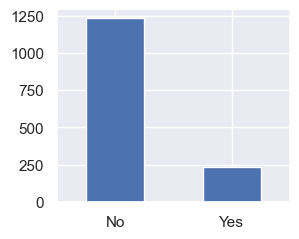

In [267]:
vc = hr_df["Attrition"].value_counts()
print(vc)
hr_df["Attrition"].value_counts().plot.bar(rot=0, figsize=(3, 2.5));

In [268]:
class HRDataset(Dataset):
    feature_encoder: OrdinalEncoder
    scaler: StandardScaler
    target_encoder: LabelEncoder
    num_features: int
    classes: t.List[str]

    data: torch.Tensor
    targets: torch.Tensor

    def __init__(
            self,
            df: pd.DataFrame,
            feature_encoder: OrdinalEncoder = None,
            scaler: StandardScaler = None,
            target_encoder: LabelEncoder = None,
    ):
        if feature_encoder:
            self.feature_encoder = feature_encoder
            encode_features = self.feature_encoder.transform
        else:
            self.feature_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
            encode_features = self.feature_encoder.fit_transform

        if scaler:
            self.scaler = scaler
            scale = self.scaler.transform
        else:
            self.scaler = StandardScaler()
            scale = self.scaler.fit_transform

        if target_encoder:
            self.target_encoder = target_encoder
            encode_targets = self.target_encoder.transform
        else:
            self.target_encoder = LabelEncoder()
            encode_targets = self.target_encoder.fit_transform

        target_col = "Attrition"
        data, targets = df.drop(columns=[target_col]), df[target_col]

        encode_cols, scale_cols = get_categorical_columns(data), get_numerical_columns(data)
        data[encode_cols] = encode_features(data[encode_cols])
        data[scale_cols] = scale(data[scale_cols])

        self.data = torch.tensor(data.to_numpy(), dtype=torch.float)
        self.num_features = self.data.size(1)
        targets = encode_targets(targets)
        self.classes = [str(cls) for cls in self.target_encoder.classes_]
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return self.targets.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [269]:
train_df, test_df = train_test_split(hr_df, test_size=0.25, random_state=0)

train_dataset = HRDataset(train_df)
test_dataset = HRDataset(
    test_df,
    feature_encoder=train_dataset.feature_encoder,
    scaler=train_dataset.scaler,
    target_encoder=train_dataset.target_encoder,
)
len(train_dataset), len(test_dataset), train_dataset.num_features, train_dataset.classes

(1102, 368, 19, ['No', 'Yes'])

## Построение и обучение модели

In [270]:
def get_weights(targets: torch.Tensor) -> torch.Tensor:
    _, counts = targets.unique(return_counts=True)
    return counts.max() / counts


def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        epochs: int,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[t.List[float], t.List[float], t.List[float], t.List[float]]:
    train_losses, train_accuracy_list = [], []
    test_losses, test_accuracy_list = [], []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)

        train_loss, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer, verbose, device)
        print(f"Train Error: loss: {train_loss:.6f}, accuracy: {train_accuracy:.4f}")
        train_losses.append(train_loss)
        train_accuracy_list.append(train_accuracy)

        test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn, device)
        print(f" Test Error: loss: {test_loss:.6f}, accuracy: {test_accuracy:.4f}\n")
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)

        torch.cuda.empty_cache()
    return train_losses, train_accuracy_list, test_losses, test_accuracy_list


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, avg_accuracy = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_true = torch.flatten(y).detach().cpu()
        y_pred = torch.flatten(pred.argmax(1)).detach().cpu()
        accuracy = metrics.accuracy_score(y_true, y_pred)

        avg_loss += loss
        avg_accuracy += accuracy
        if verbose and batch % verbose == 0:
            print(f"[{batch * len(x):>4d}/{size:>4d}]: loss: {loss:.6f}, accuracy: {accuracy:.4f}")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return (avg_loss / num_batches).item(), avg_accuracy / num_batches


@torch.no_grad()
def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.eval()
    y_true, y_pred = get_y_true_y_pred(model, dataloader, device)
    return loss_fn(y_pred, y_true).item(), metrics.accuracy_score(y_true.cpu(), y_pred.argmax(1).cpu())


@torch.no_grad()
def get_y_true_y_pred(
        model: nn.Module,
        dataloader: DataLoader,
        device: str = CPU,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        y_test.append(y)
        y_pred.append(pred)

        del x
        torch.cuda.empty_cache()

    return torch.flatten(torch.vstack(y_test)), torch.vstack(y_pred)


def plot_train_test(
        train_losses: t.List[float],
        train_accuracy: t.List[float],
        test_losses: t.List[float],
        test_accuracy: t.List[float],
) -> None:
    fig, axes = plt.subplots(2, 1, figsize=(6, 7))
    epochs = torch.arange(len(train_losses))

    axes[0].plot(epochs, train_losses)
    axes[0].plot(epochs, test_losses)
    axes[0].set_ylabel("loss")
    axes[0].legend(["train", "test"])

    axes[1].plot(epochs, train_accuracy)
    axes[1].plot(epochs, test_accuracy)
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("accuracy")

In [271]:
class IncomeClassifier(nn.Module):

    def __init__(self, num_features: int, num_classes: int):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.75),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(x)

In [272]:
torch.manual_seed(0)

net = IncomeClassifier(
    num_features=train_dataset.num_features,
    num_classes=len(train_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(weight=get_weights(train_dataset.targets).to(DEVICE))
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=True)

net

IncomeClassifier(
  (classifier): Sequential(
    (0): Linear(in_features=19, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.75, inplace=False)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [273]:
%%time

train_losses, train_accuracy, test_losses, test_accuracy = common_train(
    epochs=5,
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=65,
    device=DEVICE,
)

Epoch 1
--------------------------------
[   0/1102]: loss: 0.718498, accuracy: 0.6250
[ 520/1102]: loss: 0.775089, accuracy: 0.3750
[1040/1102]: loss: 0.800864, accuracy: 0.6250
Train Error: loss: 0.758898, accuracy: 0.7354
 Test Error: loss: 0.746934, accuracy: 0.8125

Epoch 2
--------------------------------
[   0/1102]: loss: 0.956702, accuracy: 0.7500
[ 520/1102]: loss: 0.757392, accuracy: 0.6250
[1040/1102]: loss: 0.495062, accuracy: 0.7500
Train Error: loss: 0.685597, accuracy: 0.7436
 Test Error: loss: 0.810666, accuracy: 0.8125

Epoch 3
--------------------------------
[   0/1102]: loss: 1.093895, accuracy: 0.7500
[ 520/1102]: loss: 0.654389, accuracy: 0.2500
[1040/1102]: loss: 0.565505, accuracy: 0.8750
Train Error: loss: 0.667737, accuracy: 0.7080
 Test Error: loss: 0.717789, accuracy: 0.7799

Epoch 4
--------------------------------
[   0/1102]: loss: 0.525017, accuracy: 0.8750
[ 520/1102]: loss: 0.667907, accuracy: 0.6250
[1040/1102]: loss: 0.916129, accuracy: 0.6250
Train

## Оценка и выводы

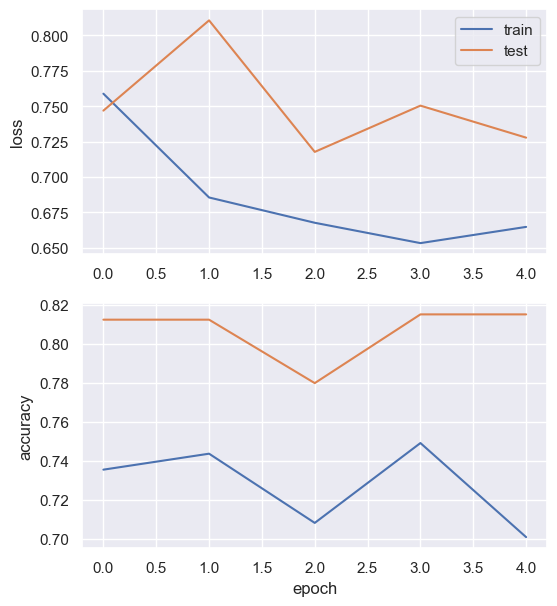

In [274]:
plot_train_test(train_losses, train_accuracy, test_losses, test_accuracy)

In [275]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader, DEVICE)
y_true, y_pred = y_true.cpu(), y_pred.argmax(1).cpu()

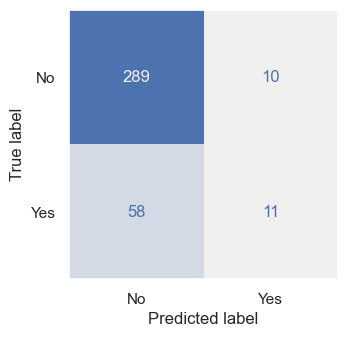

In [276]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=test_dataset.classes,
    colorbar=False,
    xticks_rotation=0,
    cmap=sns.color_palette('light:b', as_cmap=True)
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(3.5, 3.5)

In [277]:
print(metrics.classification_report(y_true, y_pred, target_names=test_dataset.classes, zero_division=True))

              precision    recall  f1-score   support

          No       0.83      0.97      0.89       299
         Yes       0.52      0.16      0.24        69

    accuracy                           0.82       368
   macro avg       0.68      0.56      0.57       368
weighted avg       0.77      0.82      0.77       368

